In [1]:
import pandas as pd 
import numpy as np 
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Deep Neural Networks Laboratory

In this notebook, we are going to train a Neural Network step by step. 


Remember that the network we defined in notebook 1 was able to infer output values (that is, executing a forward step), but since they were not trained, the weights were still randomly initialized, and as such, the output was basically random.

Traning can be done entirely within Pytorch. However, we will also use the aid of a tool called _Weights & Biases_ for visualization.

To do this, we must import:
pip install wandb

and create an account at https://wandb.ai/


In [3]:
#!pip install wandb

#!wandb login API_KEY

In [4]:
learning_rate = 1e-4
batch_size = 16
epochs = 100

In [5]:
import wandb
import random

os.environ["WANDB_NOTEBOOK_NAME"] = "3_NeuralNetworks-iris.ipynb"

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="DNN-iris_wine",
    name="iris_run",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "DNN",
    "dataset": "IRIS",
    "epochs": epochs,
    }
)


wandb: Currently logged in as: dangeloandrea14 (disim209). Use `wandb login --relogin` to force relogin


## Dataset

A Neural Network should always be built considering the dataset at hand.

In our case, we will continue our example with the Iris Dataset we built in the previous notebook.

In [6]:
class GenericDataset(Dataset):
    def __init__(self, targets_file, data_file, transform=None, target_transform=None):
        self.targets_file = pd.read_csv(targets_file)

        scaler = StandardScaler()        
        self.data_file = pd.read_csv(data_file)
        self.data_file = scaler.fit_transform(self.data_file)
        self.data_file = pd.DataFrame(self.data_file)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets_file)

    def __getitem__(self, idx):

        
        return self.data_file.iloc[idx].to_numpy(dtype=np.float32), self.targets_file.iloc[idx].item()
    
    def get_dataset(self):
        return self.data_file, self.targets_file

In [7]:
folder = os.path.join('data', 'iris')

In [8]:
IrisDataset = GenericDataset(targets_file=os.path.join(folder, 'targets.csv'), data_file=os.path.join(folder, 'data.csv'))

In [9]:
train_size = int(0.9 * len(IrisDataset))
test_size = len(IrisDataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(IrisDataset, [train_size, test_size])

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [11]:
next(iter(train_dataloader))

[tensor([[ 0.3110, -1.0506,  1.0471,  0.2647],
         [-1.1430, -0.1250, -1.3413, -1.3130],
         [ 0.6745,  0.3378,  0.8765,  1.4480],
         [ 0.1898, -0.1250,  0.5922,  0.7906],
         [-1.0218, -1.7448, -0.2608, -0.2612],
         [-1.0218,  1.0321, -1.2275, -0.7871],
         [ 0.5533, -0.8192,  0.6490,  0.7906],
         [ 0.1898,  0.8007,  0.4216,  0.5276],
         [-0.9007,  1.7263, -1.2275, -1.3130],
         [-0.1737, -0.3564,  0.2510,  0.1332],
         [-0.1737, -1.2820,  0.7059,  1.0535],
         [-0.9007,  1.0321, -1.3413, -1.1815],
         [ 0.1898, -0.3564,  0.4216,  0.3962],
         [ 0.6745, -0.8192,  0.8765,  0.9221],
         [-1.1430,  0.1064, -1.2844, -1.4444],
         [-1.2642,  0.1064, -1.2275, -1.3130]]),
 tensor([2, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 0, 1, 2, 0, 0])]

In [12]:
IrisDataset.get_dataset()[0]

,0,1,2,3
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977
...,...,...,...,...
145,1.038005,-0.124958,0.819624,1.447956
146,0.553333,-1.281972,0.705893,0.922064
147,0.795669,-0.124958,0.819624,1.053537
148,0.432165,0.800654,0.933356,1.447956


## Neural Network

Pytorch is useful to build fully customizable Neural Networks.
Keep in mind these three things:

1. Our Neural Network will extend the class ```nn.Module```. 

2. The layers will be initialized inside ```__init__```.

3. The operations on the input data are defined in the ```forward``` method.

In [13]:
class FirstNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 40)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(40, 50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 20)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(20, 3)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

In [14]:
model = FirstNeuralNetwork()
model.to(device)

FirstNeuralNetwork(
  (fc1): Linear(in_features=4, out_features=40, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=40, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=20, bias=True)
  (relu3): ReLU()
  (output_layer): Linear(in_features=20, out_features=3, bias=True)
)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
  
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    pred = model(X)

    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  #evaluating
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)

      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  
  return 100*correct, test_loss

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    acc, loss = test_loop(test_dataloader, model, loss_fn)
    accuracies.append(acc)
    wandb.log({"accuracy": acc, "loss": loss})
print("Done!")
wandb.finish()

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.086089 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.081960 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 53.3%, Avg loss: 1.078227 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 60.0%, Avg loss: 1.073988 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 66.7%, Avg loss: 1.069861 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 1.065320 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 1.060679 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 1.056224 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 1.051478 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 1.046364 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg los

accuracy,▁▂▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇███████████████████
loss,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,93.33333
loss,0.27421


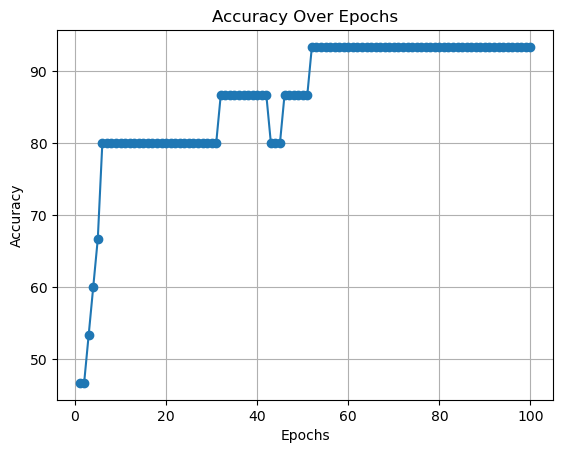

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(accuracies) + 1)

plt.plot(epochs, accuracies, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

## Example predictions

In [18]:
i = 0

for X,y in test_dataloader:
  #print('label', y)
  print(y)

  X, y = X.to(device), y.to(device)

  pred = model(X)
  pred = pred.argmax(1)
  print(pred)
  #print('prediction:', pred)
  print("____________________")

  if i > 3:
    break

  i += 1

tensor([2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1])
tensor([2, 1, 0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 1])
____________________


## Is the dataset unabalanced?

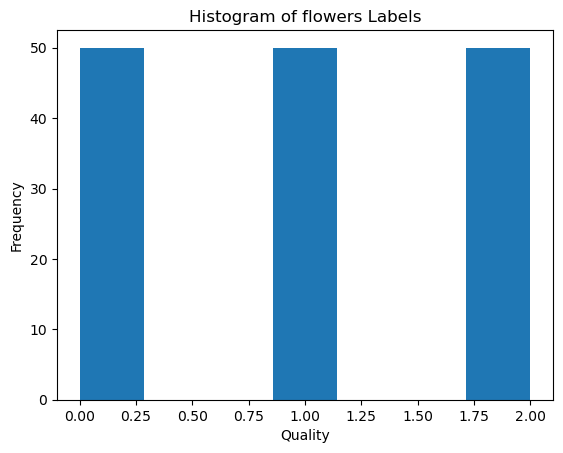

In [19]:
labels = IrisDataset.get_dataset()[1].to_numpy()

#plot histogram
plt.hist(labels, bins=7)
plt.title('Histogram of flowers Labels')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()